# Minimal Working Example of SGD Training Loop in PyTorch

Epoch 5/50, LR: 0.0976
  Train Loss: 0.324695
  Val Loss: 0.310937
  EMA Val Loss: 0.339958
Epoch 10/50, LR: 0.0905
  Train Loss: 0.304802
  Val Loss: 0.268911
  EMA Val Loss: 0.250925
Epoch 15/50, LR: 0.0796
  Train Loss: 0.338474
  Val Loss: 0.360578
  EMA Val Loss: 0.245650
Epoch 20/50, LR: 0.0658
  Train Loss: 0.309533
  Val Loss: 0.322126
  EMA Val Loss: 0.245751
Epoch 25/50, LR: 0.0505
  Train Loss: 0.297412
  Val Loss: 0.284548
  EMA Val Loss: 0.246450
Epoch 30/50, LR: 0.0352
  Train Loss: 0.295833
  Val Loss: 0.250257
  EMA Val Loss: 0.247322
Epoch 35/50, LR: 0.0214
  Train Loss: 0.281134
  Val Loss: 0.256020
  EMA Val Loss: 0.247535
Epoch 40/50, LR: 0.0105
  Train Loss: 0.279349
  Val Loss: 0.247483
  EMA Val Loss: 0.247632
Epoch 45/50, LR: 0.0034
  Train Loss: 0.274359
  Val Loss: 0.244522
  EMA Val Loss: 0.247221
Epoch 50/50, LR: 0.0010
  Train Loss: 0.271638
  Val Loss: 0.247032
  EMA Val Loss: 0.247059


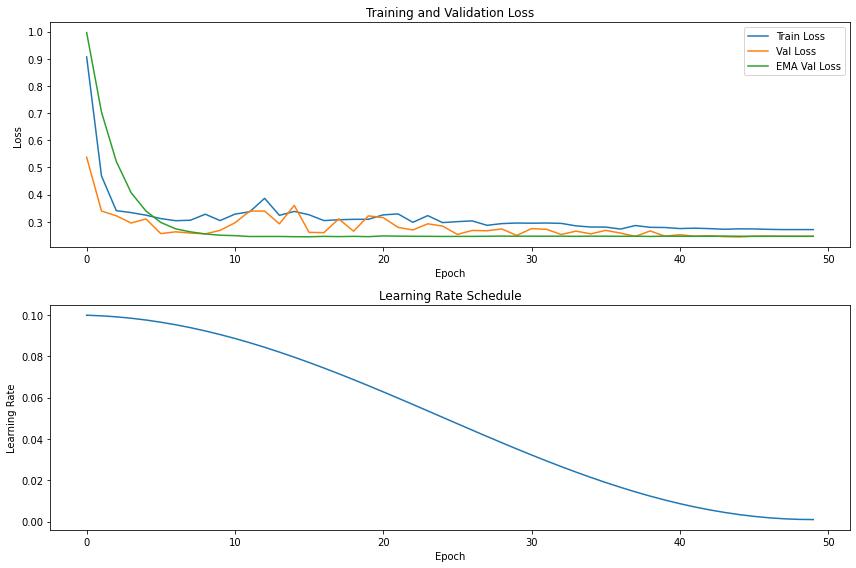


True weights vs. Learned weights:
  w0: True=0.3367, Model=0.3380, EMA=0.3380
  w1: True=0.1288, Model=0.1040, EMA=0.1040
  w2: True=0.2345, Model=0.2313, EMA=0.2314
  w3: True=0.2303, Model=0.2367, EMA=0.2339
  w4: True=-1.1229, Model=-1.1252, EMA=-1.1260
  bias: True=-0.1863, Model=-0.1665, EMA=-0.1654


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.swa_utils import AveragedModel
import matplotlib.pyplot as plt
import numpy as np

# set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. create synthetic dataset
def generate_data(n=1000, d=5, noise=0.5):
    # true weights and bias
    w_true = torch.randn(d, 1)
    b_true = torch.randn(1)
    
    # input features
    X = torch.randn(n, d)
    
    # target values with noise
    y = X @ w_true + b_true*torch.ones(n, 1) + noise * torch.randn(n, 1)
    
    return X, y, w_true, b_true

X, y, w_true, b_true = generate_data()

# split into train/val sets
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

# create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 2. define model
class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x)

model = LinearModel(X.shape[1])

# 3. set up optimizer with momentum and weight decay
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,           # initial learning rate
    momentum=0.9,     # momentum coefficient
    weight_decay=1e-4 # L2 regularization
)

# 4. learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.001)

# 5. EMA model
ema_model = AveragedModel(model, avg_fn=lambda avg, param, _: 0.99 * avg + 0.01 * param)

# 6. train function
def train_epoch(model, ema_model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # zero gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # update EMA model
        ema_model.update_parameters(model)
        
        train_loss += loss.item() * X_batch.size(0)
    
    return train_loss / len(train_loader.dataset)

# 7. validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    
    return val_loss / len(val_loader.dataset)

# 8. training loop
criterion = nn.MSELoss()
num_epochs = 50

# tracking metrics
train_losses = []
val_losses = []
val_losses_ema = []
learning_rates = []

# training
for epoch in range(num_epochs):
    # train for one epoch
    train_loss = train_epoch(model, ema_model, train_loader, optimizer, criterion)
    
    # validate standard model
    val_loss = validate(model, val_loader, criterion)
    
    # validate EMA model
    val_loss_ema = validate(ema_model.module, val_loader, criterion)
    
    # update learning rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_losses_ema.append(val_loss_ema)
    learning_rates.append(current_lr)
    
    # display progress
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.4f}")
        print(f"  Train Loss: {train_loss:.6f}")
        print(f"  Val Loss: {val_loss:.6f}")
        print(f"  EMA Val Loss: {val_loss_ema:.6f}")

# 9. plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.plot(range(num_epochs), val_losses_ema, label='EMA Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(range(num_epochs), learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.tight_layout()
plt.show()

# 10. compare final weights to true weights
with torch.no_grad():
    print("\nTrue weights vs. Learned weights:")
    for i, (true, learned, ema_learned) in enumerate(zip(
            w_true, model.linear.weight[0], ema_model.module.linear.weight[0])):
        print(f"  w{i}: True={true.item():.4f}, Model={learned.item():.4f}, EMA={ema_learned.item():.4f}")
    
    print(f"  bias: True={b_true.item():.4f}, "
          f"Model={model.linear.bias.item():.4f}, "
          f"EMA={ema_model.module.linear.bias.item():.4f}")
